### Wstęp do Uczenia Maszynowego 
##### Laboratorium 12

In [1]:
import os
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

### Voting & Stacking

### Zadanie 0
---


Dla danych (X, y) korzystając z metody `StackingClassifier` i `VotingClassifier` zbuduj dwa pipeline, które będą zakończone komitetami klasyfikatorów, zbudowanych z 4 różnych algorytmów uczenia maszynowego.

a) Jaka jest różnica w jakości poszczególnych modeli, a całego stackingu i votingu?

b) Czy algorytmy mają podobny wkład w ostateczną predykcję czy jeden z algorytmów dominuje?


In [3]:
X = pd.read_csv("../lab08/X.csv")
y = pd.read_csv("../lab08/y.csv")

In [4]:
y.loc[y.income == '<=50K.'] = '<=50K'
y.loc[y.income == '>50K.'] = '>50K'

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1812)

In [6]:
# przetwarzanie danych wejściowych
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include=np.object_))
    ])

In [7]:
# bazowy model drzewa - ocena potencjału danych

tree_model_default = Pipeline([('preprocessing', col_trans),
                               ('tree', DecisionTreeClassifier())
                               ])

tree_model_default.fit(X_train, y_train.income)
print("Accuracy default tree:", tree_model_default.score(X_test, y_test.income))

Accuracy default tree: 0.8174838775719111


In [8]:
y_train.income

18501    <=50K
24647    <=50K
43290    <=50K
17185    <=50K
32045    <=50K
         ...  
3456     <=50K
11085    <=50K
7542     <=50K
41015    <=50K
17755     >50K
Name: income, Length: 39073, dtype: object

In [9]:
# Stacking
estimators = [('rl', LogisticRegression(max_iter=500)),
              ('tree', DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('knn', KNeighborsClassifier())]

stacking_pipeline = Pipeline([('preprocessing', col_trans),
                           ('model', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
                           ])

stacking_pipeline.fit(X_train, y_train.income)
print("Accuracy Stacking Model:", stacking_pipeline.score(X_test, y_test.income))


Accuracy Stacking Model: 0.8619101238611936


In [10]:
stacking_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CFB844150>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CFB9A94D0>)])),
                ('model',
                 StackingClassifier(estimators=[('rl',
                                                 LogisticRegression(max_iter=500)),
                                                ('tree',
                                                 DecisionTreeClassifier()),
                                                ('rf',
                                                 RandomForestClassifier()),
                                                ('knn',
                                                 KNeighborsClassifier())],
                                    final_estimator=LogisticRegression()))])

In [11]:
# Voting
estimators = [('rl', LogisticRegression(max_iter=500)),
              ('tree', DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('knn', KNeighborsClassifier())]

voting_pipeline = Pipeline([('preprocessing', col_trans),
                           ('model', VotingClassifier(estimators=estimators))
                           ])

voting_pipeline.fit(X_train, y_train.income)
print("Accuracy Stacking Model:", voting_pipeline.score(X_test, y_test.income))


Accuracy Stacking Model: 0.8547446002661481


In [12]:
voting_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CFB844150>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CFB9A94D0>)])),
                ('model',
                 VotingClassifier(estimators=[('rl',
                                               LogisticRegression(max_iter=500)),
                                              ('tree',
                                               DecisionTreeClassifier()),
                                              ('rf', RandomForestClassifier()),
                                              ('knn',
                                               KNeighborsClassifier())]))])

### $k$-średnich *($k$-means)*

###### $K$ - średnich jest prostym podejściem do podziału zbioru danych na $k$ odrębnych, nienakładających się skupień. Aby wykonać $k$ - średnich musimy najpierw określić żądaną liczbę skupień $k$; następnie algorytm algorytm $k$-średnich przypisze każdą obserwację do dokładnie jednego z $k$ skupień.


<img src="kmeans.png"  width="500"/>

###### *An Introduction to Statistical Learning with Applications in Python*


### Algorytm
1) *Ustalamy liczbę skupień*
2) *Ustalamy wstępne środki skupień*
3) *Obliczamy odległości obiektów (obserwacji) od środków skupień*
4) Przypisujemy obiekty do skupień
5) Ustalamy nowe środki skupień
6) Wykonujemy kroki 3), 4), 5) do czasu, aż warunek zatrzymania zostanie spełniony

<img src="centroids_iterations.webp"  width="600"/>

[*K-Means Clustering in Python: A Practical Guide*](https://realpython.com/k-means-clustering-python/)

### Dane

In [13]:
np.random.seed(0)
X = np.random.standard_normal((50, 2))
X[:25,0] += 3
X[:25,1] -= 4

<Axes: >

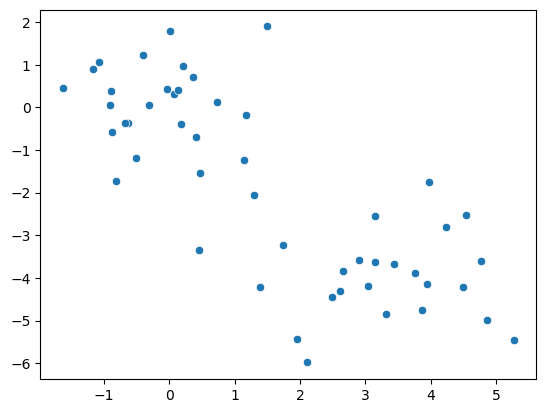

In [14]:
sns.scatterplot(x = X[:,0], y = X[:,1])

### Zadanie 1
---
Przygotuj model k-średnich dla liczby klastrów równej 2.
Użyj funkcji `KMeans()`. Przedstaw na wykresie przydział obserwacji do utworzonych skupień.

In [15]:
kmeans = KMeans(n_clusters=2, n_init=10).fit(X)

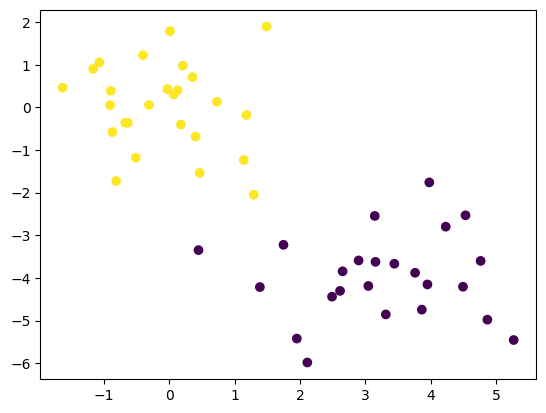

In [16]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_)

### Zadanie 2
---
Przygotuj model $k$-średnich dla k = 3. Narysuj wykres pokazujący przynależność obserwacji do utworzonych klastrów oraz zaznacz wyznaczone centroidy.

In [17]:
kmeans = KMeans(n_clusters=3, random_state=2, n_init=20).fit(X)

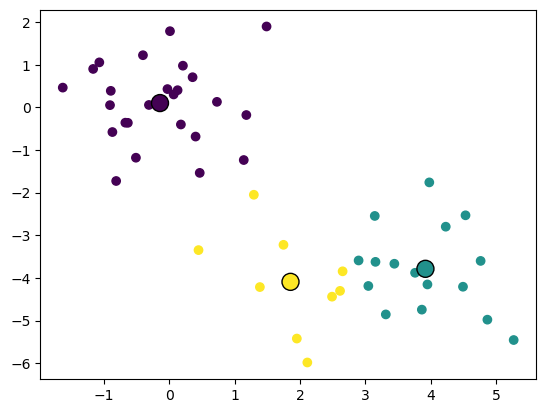

In [18]:
plt.scatter(X[:, 0], X[:, 1], c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = np.unique(kmeans.labels_), edgecolors="black", s=150)


### Zadanie 3
---
Za co jest odpowiedzialny parametr `n_init`? Porównaj model dla `n_init = 1` oraz `n_init = 20` używając `.interia_`.


In [19]:
kmeans1 = KMeans(n_clusters=3,
                random_state=3,
                n_init=1).fit(X)
kmeans20 = KMeans(n_clusters=3,
                  random_state=3,
                  n_init=20).fit(X)
kmeans1.inertia_, kmeans20.inertia_

(76.85131986999251, 75.06261242745386)

### Jak wybrać optymalne $k$?

### Zadanie 4
---
Rozważ $k$ z przedziału `range(1, 11)`, przyygotuj dla zadanego $k$ model i wylicz SSE. Przedstaw rezultaty na wykresie.

In [20]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

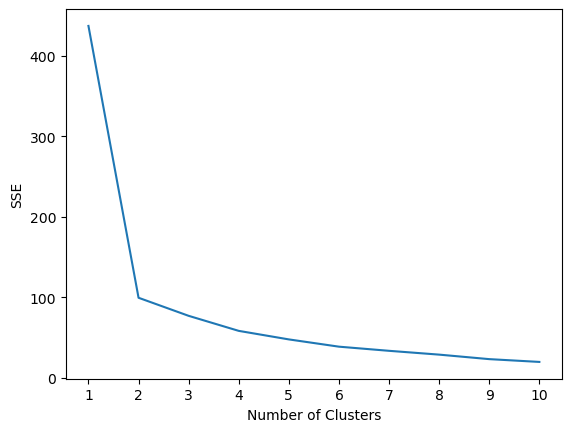

In [21]:
plt.plot(range(1,11),sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")